In [2]:
!pip install gradio yfinance --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import gradio as gr

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/KALAIVARSAN2006/stock-price-prediction/main/price-prediction.csv')
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (3322, 15)


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']]

In [6]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Close    0
dtype: int64


In [7]:
df.dropna(inplace=True)

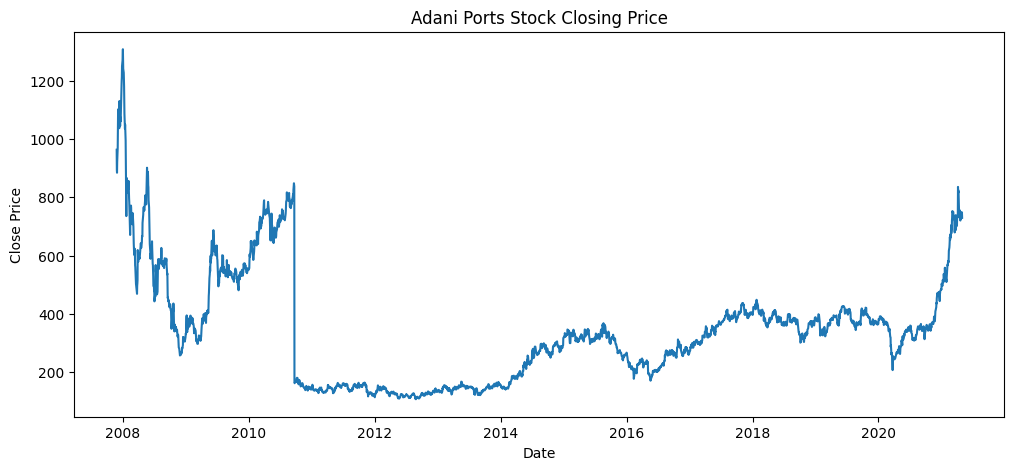

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(df['Close'])
plt.title("Adani Ports Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['Close']])

In [10]:
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0065 - val_loss: 4.1928e-04
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 9.1963e-04 - val_loss: 3.2117e-04
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 5.8745e-04 - val_loss: 3.8040e-04
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 7.0592e-04 - val_loss: 3.4157e-04
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 5.3529e-04 - val_loss: 2.2932e-04
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 6.2390e-04 - val_loss: 2.1029e-04
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 5.4904e-04 - val_loss: 2.1639e-04
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 3.0627e-04 - val_loss: 3.3215e-04
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 3.8298e-04 - val_loss: 1.8229e-04
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 4.4081e-04 - val_loss: 1.6208e-04
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 2.6022e-04

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


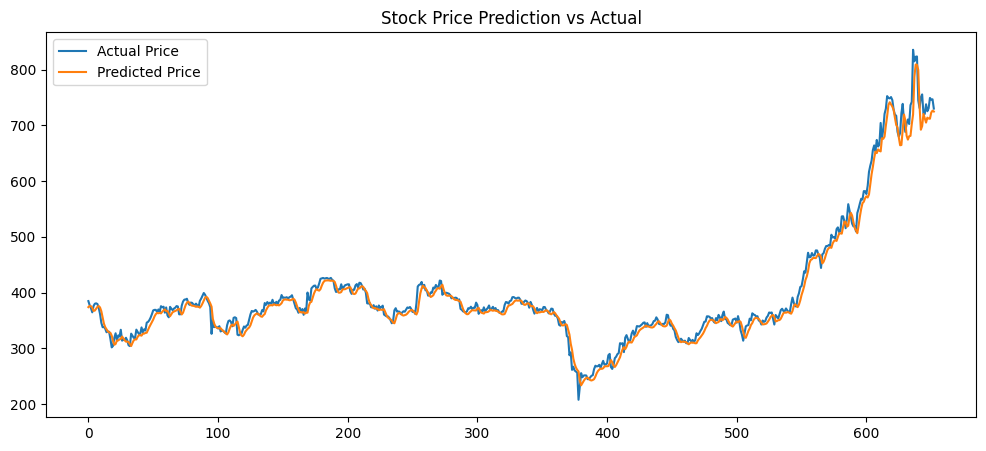

MSE: 196.3692219892551
R2 Score: 0.9834034416116005


In [ ]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))
true_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12,5))
plt.plot(true_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.legend()
plt.title("Stock Price Prediction vs Actual")
plt.show()

print("MSE:", mean_squared_error(true_prices, predicted_prices))
print("R2 Score:", r2_score(true_prices, predicted_prices))

In [14]:
recent_data = scaled_data[-window_size:]

def predict_price():
    input_seq = recent_data.reshape(1, window_size, 1)
    prediction = model.predict(input_seq)
    predicted_price = scaler.inverse_transform(prediction)[0][0]
    return round(predicted_price, 2)

iface = gr.Interface(fn=predict_price,
                     inputs=[],
                     outputs=gr.Number(label="📈 Predicted Next Closing Price"),
                     title="📊 Stock Price Predictor",
                     description="Predicts the next day's stock closing price using LSTM and time series data.")

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://01a026ac050c341e79.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
